In [5]:
import SimFunctions
import SimClasses
import SimRNG
import SimRNG_Modified
import simpy
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest
import pickle
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)

ZSimRNG = SimRNG_Modified.InitializeRNSeed()


# Data Loading from BikeShare Data

In [6]:
subset_df = pd.read_csv("10_station_subset.csv")

In [7]:
subset_df

,Unnamed: 0,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips
0,0,17516168,11.000000,7066,08/01/2022 01:19,Willcocks St / St. George St,7406.0,08/01/2022 01:30,Victoria St / Queen St E,6913,Annual Member,5
1,1,17523130,15.266667,7066,08/01/2022 12:43,Willcocks St / St. George St,7406.0,08/01/2022 12:58,Victoria St / Queen St E,4245,Casual Member,5
2,2,17575636,11.966667,7066,08/03/2022 14:23,Willcocks St / St. George St,7406.0,08/03/2022 14:35,Victoria St / Queen St E,5721,Annual Member,5
3,3,17666877,10.833333,7066,08/06/2022 23:03,Willcocks St / St. George St,7406.0,08/06/2022 23:14,Victoria St / Queen St E,950,Annual Member,5
4,4,17826642,10.550000,7066,08/13/2022 10:37,Willcocks St / St. George St,7406.0,08/13/2022 10:48,Victoria St / Queen St E,3556,Annual Member,5
...,...,...,...,...,...,...,...,...,...,...,...,...
889,907,18277265,12.733333,7066,08/30/2022 15:45,Willcocks St / St. George St,7408.0,08/30/2022 15:58,University Ave / Armoury St,2820,Casual Member,2
890,908,18149625,7.450000,7033,08/25/2022 17:23,Union Station,7408.0,08/25/2022 17:31,University Ave / Armoury St,2306,Annual Member,1
891,909,18211548,13.500000,7657,08/27/2022 19:58,1 Market St - SMART,7389.0,08/27/2022 20:12,College Park- Gerrard Entrance,2379,Annual Member,2
892,910,18308656,13.516667,7657,08/31/2022 18:17,1 Market St - SMART,7389.0,08/31/2022 18:31,College Park- Gerrard Entrance,5005,Casual Member,2


# Arrival Rates

In [8]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by station and 30-minute interval, and count the number of trips that started in each group
Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'],subset_df['Start Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')
#Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')

# Calculate the arrival rate at each station and 30-minute interval (trips per hour)
Start_Station_HalfHour_Arrivals['ArrivalRate (per min)'] = Start_Station_HalfHour_Arrivals['ArrivalRate (per 30min)'] / 30

# Display the result
arrival_df = Start_Station_HalfHour_Arrivals.sort_values(by="Start Time (per 30min)")
arrival_df


,Start Station Name,Start Station Id,Start Time (per 30min),ArrivalRate (per 30min),ArrivalRate (per min)
104,Elm St/ University Ave (East Side),7647,0.0,1,0.033333
141,Toronto Eaton Centre (Yonge St),7269,0.0,1,0.033333
65,College Park- Gerrard Entrance,7389,0.0,4,0.133333
23,Church St / Alexander St,7044,0.0,1,0.033333
66,College Park- Gerrard Entrance,7389,1.0,3,0.100000
...,...,...,...,...,...
22,1 Market St - SMART,7657,47.0,2,0.066667
64,Church St / Alexander St,7044,47.0,3,0.100000
209,Union Station,7033,47.0,1,0.033333
103,College Park- Gerrard Entrance,7389,47.0,2,0.066667


In [9]:
desc = arrival_df.describe()[1:2].values
mean_arrival_30 = desc[0][2]
mean_arrival_min = desc[0][3]

customer_per_30min = mean_arrival_30
customer_per_min = mean_arrival_min
print(f"Customers Per 30 min = {customer_per_30min}")
print(f"Customers Per min = {customer_per_min}")


Customers Per 30 min = 3.204301075268817
Customers Per min = 0.1068100358422939


- There is approx 0.10 customer every minute in the dataset or 1 customer every 10min

# Probability of Destinations

In [10]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

start_end_station_halfhour_trips = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfTrips')
total_trips = start_end_station_halfhour_trips.groupby(['Start Station Name', 'Start Time (per 30min)'])['NumOfTrips'].sum().reset_index(name='TotalTrips')

start_end_station_prob = pd.merge(start_end_station_halfhour_trips, total_trips, on=['Start Station Name', 'Start Time (per 30min)'])
start_end_station_prob['Probability'] = start_end_station_prob['NumOfTrips'] / start_end_station_prob['TotalTrips']

station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Name', 'Start Time (per 30min)'], columns=['End Station Name'], values='Probability').fillna(0)#.reset_index().fillna(0)
name_prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
name_prob_df


,End Station Name,1 Market St - SMART,Church St / Alexander St,College Park- Gerrard Entrance,Elm St/ University Ave (East Side),King St E / Jarvis St,Toronto Eaton Centre (Yonge St),Union Station,University Ave / Armoury St,Victoria St / Queen St E,Willcocks St / St. George St
Start Station Name,Start Time (per 30min),,,,,,,,,,
Elm St/ University Ave (East Side),0.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
Toronto Eaton Centre (Yonge St),0.0,0.0,1.000000,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
College Park- Gerrard Entrance,0.0,0.0,0.000000,0.000000,0.25,0.0,0.0,0.00,0.0,0.750000,0.0
Church St / Alexander St,0.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
College Park- Gerrard Entrance,1.0,0.0,0.333333,0.000000,0.00,0.0,0.0,0.00,0.0,0.666667,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1 Market St - SMART,47.0,0.0,0.000000,0.000000,0.00,0.0,1.0,0.00,0.0,0.000000,0.0
Church St / Alexander St,47.0,0.0,0.000000,0.333333,0.00,0.0,0.0,0.00,0.0,0.666667,0.0
Union Station,47.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0


Real Probability
End Station Name
1 Market St - SMART                   0.000000
Church St / Alexander St              0.333333
College Park- Gerrard Entrance        0.000000
Elm St/ University Ave (East Side)    0.000000
King St E / Jarvis St                 0.000000
Toronto Eaton Centre (Yonge St)       0.000000
Union Station                         0.000000
University Ave / Armoury St           0.000000
Victoria St / Queen St E              0.666667
Willcocks St / St. George St          0.000000
Name: (College Park- Gerrard Entrance, 1.0), dtype: float64

Simulated Probability
{'Victoria St / Queen St E': 0.65, 'Church St / Alexander St': 0.35}


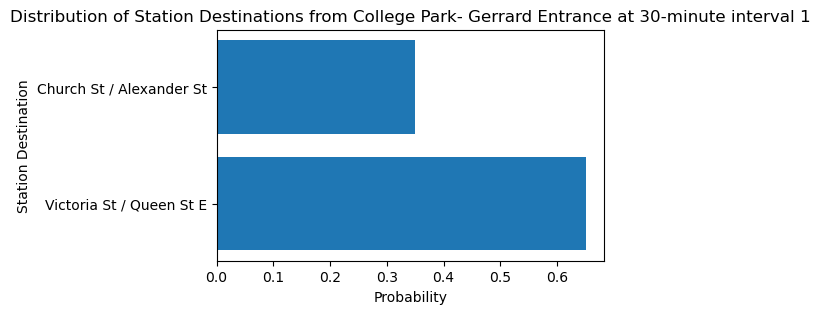

In [11]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(100):
    start_station = 'College Park- Gerrard Entrance'
    start_time = 1  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(5, 3))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at 30-minute interval {start_time}')
plt.show()


In [12]:
station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Id', 'Start Time (per 30min)'], columns=['End Station Id'], values='Probability').fillna(0)
prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
prob_df.head()

End Station Id                           7009.0  7033.0    7044.0  7066.0  \
Start Station Id Start Time (per 30min)                                     
7269             0.0                        0.0     0.0  1.000000     0.0   
7044             0.0                        0.0     0.0  0.000000     0.0   
7647             0.0                        0.0     0.0  0.000000     0.0   
7389             0.0                        0.0     0.0  0.000000     0.0   
                 1.0                        0.0     0.0  0.333333     0.0   

End Station Id                           7269.0  7389.0    7406.0  7408.0  \
Start Station Id Start Time (per 30min)                                     
7269             0.0                        0.0     0.0  0.000000     0.0   
7044             0.0                        0.0     1.0  0.000000     0.0   
7647             0.0                        0.0     1.0  0.000000     0.0   
7389             0.0                        0.0     0.0  0.750000     0.0   
                 1.0                        0.0     0.0  0.666667     0.0   

End Station Id                           7647.0  7657.0  
Start Station Id Start Time (per 30min)                  
7269             0.0                       0.00     0.0  
7044             0.0                       0.00     0.0  
7647             0.0                       0.00     0.0  
7389             0.0                       0.25     0.0  
                 1.0                       0.00     0.0

# Trip Durations

In [13]:
with open('google_bike_trip_10_est.pickle', 'rb') as f:
    google_bike_trip = pickle.load(f)
    
google = pd.DataFrame((np.array(google_bike_trip)), columns=["Google"])
observed = pd.DataFrame(np.array((subset_df["Trip_Duration"].values)), columns=["Observed"])
trip_reg_df = pd.DataFrame({"Observed": np.array((subset_df["Trip_Duration"].values)*60), "Google": np.array(google_bike_trip)})
trip_reg_df.head()

,Observed,Google
0,660.0,573
1,916.0,573
2,718.0,573
3,650.0,573
4,633.0,573


Pre Residual Mean -4.689264139803793e-16
Pre Residual Variance: 0.24220362012380336

New Resiudal Mean 5.066789642584607e-16
New Residual Variance: 0.1153369265240432

Beta: 0.5036900622620087
Intercept: 3.2065647643831676
R^2: 0.6344864053397077


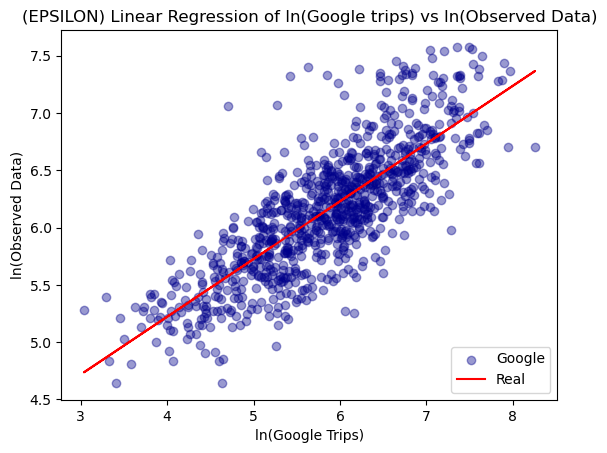

In [14]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X_i = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X_i, y)
predictions = model.predict(X_i)
score = model.score(X_i, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_mean = np.mean(residuals)
residual_var = np.var(residuals)
residual_std = np.std(residuals)

error_sd = np.sqrt(residual_var)
errors = np.random.normal(
    loc=residual_mean, scale=residual_std, size=len(residuals))
epsilon = residuals - errors

new_X = X + epsilon
new_X_i = np.array(new_X).reshape(-1, 1)

# Fit linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(new_X_i, y)
new_predictions = model.predict(new_X_i)

# Calculate R-squared and print results
r2 = model.score(new_X_i, y)
new_beta = model.coef_[0]
new_intercept = model.intercept_

new_residuals = y - new_predictions
new_residual_mean = np.mean(new_residuals)
new_residual_var = np.var(new_residuals)
new_residual_std = np.std(new_residuals)
print("Pre Residual Mean", residual_mean)
print("Pre Residual Variance:", residual_var)
print()

print("New Resiudal Mean", new_residual_mean)
print("New Residual Variance:", new_residual_var)
print()
print('Beta:', new_beta)
print('Intercept:', new_intercept)
print("R^2:", r2)

plt.scatter(new_X_i, y, color='darkblue', alpha=0.4)
plt.plot(new_X_i, new_predictions, color='red')
plt.title("(EPSILON) Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


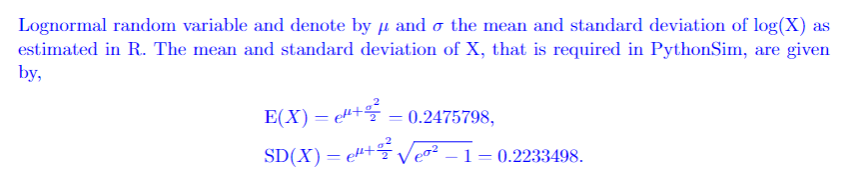

In [15]:
global E_x, SD_X

u = residual_mean
std = np.sqrt(residual_var)
E_x = np.exp(u + ((std**2)/2))
SD_x = np.exp(u + ((std**2)/2)) * np.sqrt(np.exp(std**2) - 1)
print(E_x, SD_x)


1.1287398235889954 0.590896741566976


### Average Trip Durations between Specific Stations

In [16]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by start and end station and 30-minute interval, and calculate the average trip duration in seconds for each group
Station_HalfHour_AvgDuration = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

Station_HalfHour_AvgDuration['Avg_Trip_Duration'] = Station_HalfHour_AvgDuration['Avg_Trip_Duration']

# Display the result
avg_trip_duration = Station_HalfHour_AvgDuration.sort_values(by="Start Time (per 30min)")
avg_trip_duration


,Start Station Name,Start Station Id,End Station Name,End Station Id,Start Time (per 30min),Avg_Trip_Duration
171,College Park- Gerrard Entrance,7389,Victoria St / Queen St E,7406.0,0.0,3.838889
36,Church St / Alexander St,7044,College Park- Gerrard Entrance,7389.0,0.0,12.450000
262,Toronto Eaton Centre (Yonge St),7269,Church St / Alexander St,7044.0,0.0,14.100000
115,College Park- Gerrard Entrance,7389,Elm St/ University Ave (East Side),7647.0,0.0,11.666667
201,Elm St/ University Ave (East Side),7647,College Park- Gerrard Entrance,7389.0,0.0,2.100000
...,...,...,...,...,...,...
100,Church St / Alexander St,7044,Victoria St / Queen St E,7406.0,47.0,8.200000
301,Toronto Eaton Centre (Yonge St),7269,Union Station,7033.0,47.0,5.000000
118,College Park- Gerrard Entrance,7389,Elm St/ University Ave (East Side),7647.0,47.0,3.100000
347,Union Station,7033,College Park- Gerrard Entrance,7389.0,47.0,7.700000


In [17]:
avg_trip_duration["Avg_Trip_Duration"].describe()


count    537.000000
mean       9.327115
std        5.436479
min        1.733333
25%        5.616667
50%        8.100000
75%       11.233333
max       31.900000
Name: Avg_Trip_Duration, dtype: float64

# Global Variables

- Decide on the time units
    - Min 

In [18]:
global E_x, SD_X

# Classes

In [18]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)

    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None

    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list


class Customer:
    def __init__(self, customer_id, start_s_id, bike=None):
        self.customer_id = customer_id
        self.start_s_id = start_s_id
        self.end_s_id = 0
        self.station_level = 0
        self.bike = bike

    def rent_bike(self, T):
        station = StationDict[self.start_s_id]
        print(f"Customer Arrives at S{station.id} with Level: {station.level}")

        if station.level > 0:
            self.bike = station.rent_bike()
            self.station_level = station.level
            print("(Customer Rent Bikes) Customer ID: {} | Bike ID {} || From: S{} -> Remaining Level: {}".format(self.customer_id,
                                                                                                                  self.bike,
                                                                                                                  self.start_s_id,
                                                                                                                  self.station_level))
            self.Departure(T)
        else:
            print(
                f"    Customer {self.customer_id} CANNOT RENT BIKE -- EMPTY STATION {self.start_s_id} w/ level {self.station_level} -- EMPTY")

    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]
        destination_station.return_bike(bike)
        self.station_level = destination_station.level
        

    def Departure(self, T):
        end_s_id = self.Destination(T=T, retrial=0)
        self.end_s_id = end_s_id

        trip_time = self.TripDuration(T)

        SimFunctions.Schedule(Calendar, "Bike_Arrival", min(30, trip_time))
        return end_s_id

    def TripDuration(self, T):
        """
        Calcuates the Trip time between two stations, and has a min trip length of 2 min
        """

        print(f"Customer ID = {self.customer_id} | T={T} | start_id = {self.start_s_id} | end_id = {self.end_s_id}")

        duration_data = avg_trip_duration[(avg_trip_duration["Start Time (per 30min)"] == T) &
                                          (avg_trip_duration["Start Station Id"] == self.start_s_id) &
                                          (avg_trip_duration["End Station Id"] == self.end_s_id)]["Avg_Trip_Duration"].values[0]

        trip_time = duration_data * SimRNG_Modified.Lognormal(ZSimRNG, E_x, SD_x**2, 4)
        return max(2, np.round(trip_time))
    
    def ChoosingRoute(self, prob_df, start_s_id, start_time):
        retry = None
        try:
            start_row = prob_df.loc[(start_s_id, start_time)]
            probs = start_row.values
            end_s_id = np.random.choice(start_row.index, p=probs)
            return end_s_id
        except KeyError:
            print(
                f"No data found for start station '{start_s_id}' and start time '{start_time}'")
            retry = None
            return retry


    def Destination(self, T, retrial=0):
        """_summary_
        Finds a destination for a customer at a given time T
        
        Args:
            customer 
            T 
            retrial

        Returns:
        end_s_id (end station id)
        """

        end_s_id = None
        while end_s_id is None:
            end_s_id = self.ChoosingRoute(prob_df, start_s_id=self.start_s_id, start_time=T)

        end_station = StationDict[end_s_id]

        if self.bike is None:
            print(" Customer ID: {} Leaves from empty | From: {} -> Remaining Level {}".format(self.customer_id,
                                                                                            self.start_s_id,
                                                                                            self.station_level))
        elif retrial == 1:
            pass

        elif retrial == 0 and self.bike is not None:
            print(" (DEPARTING) Customer ID: {} | Bike ID: {} || From: S{} -> Level {} | To: S{} -> Level {}".format(self.customer_id,
                                                                                                                    self.bike,
                                                                                                                    self.start_s_id,
                                                                                                                    self.station_level,
                                                                                                                    end_station.id,
                                                                                                                    end_station.level))
        return end_s_id


# Functions

In [ ]:
def Start():
    SimFunctions.Schedule(Calendar, "Customer_Arrival", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
    
def NextCustomerID():
    if not hasattr(NextCustomerID, "counter"):
        NextCustomerID.counter = 0
    NextCustomerID.counter += 1
    return NextCustomerID.counter

## Probabilistic Functions

In [771]:
def ChoosingRoute(prob_df, start_s_id, start_time):
    """_summary_
    With given start_s_id & start_time, access the possible destinations from prob_df

    Args:
        prob_df (_type_): Pivot Table DF with probabilites of arriving to specific destination at a specific time and starting location
        start_s_id (_type_): ID
        start_time (_type_): T

    Returns:
        destination ID
    """
    retry = None
    try:
        start_row = prob_df.loc[(start_s_id, start_time)]
        probs = start_row.values
        end_s_id = np.random.choice(start_row.index, p=probs)
        return end_s_id
    except KeyError:
        print(
            f"No data found for start station '{start_s_id}' and start time '{start_time}'")
        retry = None
        return retry

start_s_id = 7647
T=1
end_s_id = ChoosingRoute(prob_df, start_s_id=start_s_id, start_time=0)
print(end_s_id)


7389.0


In [756]:
def ChoosingRoute(prob_df, start_s_id, start_time):
    """_summary_
    With given start_s_id & start_time, access the possible destinations from prob_df

    Args:
        prob_df (_type_): Pivot Table DF with probabilites of arriving to specific destination at a specific time and starting location
        start_s_id (_type_): ID
        start_time (_type_): T

    Returns:
        destination ID
    """
    retry = None
    try:
        start_row = prob_df.loc[(start_s_id, start_time)]
        probs = start_row.values
        end_s_id = np.random.choice(start_row.index, p=probs)
        return end_s_id
    except KeyError:
        print(f"No data found for start station '{start_s_id}' and start time '{start_time}'")
        retry = None
        return retry


def Destination(customer, T, retrial=0):
    """_summary_
    Finds a destination for a customer at a given time T
    
    Args:
        customer 
        T 
        retrial

    Returns:
    end_s_id (end station id)
    """
    start_s_id = customer.start_s_id

    end_s_id = None
    while end_s_id is None:
        end_s_id = ChoosingRoute(prob_df, start_s_id=start_s_id, start_time=T)

    end_station = StationDict[end_s_id]

    if customer.bike is None:
        print(" Customer ID: {} Leaves from empty | From: {} -> Remaining Level {}".format(customer.customer_id,
                                                                                           customer.start_s_id,
                                                                                           customer.station_level))
    elif retrial == 1:
        pass

    elif retrial == 0 and customer.bike is not None:
        print(" (DEPARTING) Customer ID: {} | Bike ID: {} || From: S{} -> Level {} | To: S{} -> Level {}".format(customer.customer_id,
                                                                                                                 customer.bike,
                                                                                                                 customer.start_s_id,
                                                                                                                 customer.station_level,
                                                                                                                 end_station.id,
                                                                                                                 end_station.level))
    return end_s_id


## Trip Process Functions

In [757]:
# def Customer_Arrival_Rate(T):
#     temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
#     arrival_rates = temp_df["ArrivalRate (per 30min)"].values
#     possible_station_ids = temp_df["Start Station Id"].values
#     selected_station_id = np.random.choice(possible_station_ids, p=(arrival_rates / arrival_rates.sum()))
#     arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == selected_station_id)]["ArrivalRate (per 30min)"].values[0]
#     return arrival_rate, selected_station_id

# arrival_rate, station_id = Customer_Arrival_Rate(T=9)
# mu = (30/arrival_rate)
# print(mu, arrival_rate)
# print(min(30, np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))))


In [758]:
def Customer_Arrival_Rate(T):
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    selected_station_id = np.random.choice(possible_station_ids, p=(arrival_rates / arrival_rates.sum()))
    arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == selected_station_id)]["ArrivalRate (per min)"].values[0]
    return arrival_rate, selected_station_id

def Customer_Arrival(empty_error, CustomerList, T):
    arrival_rate, station_id = Customer_Arrival_Rate(T)
    mu = 1/arrival_rate
    SimFunctions.Schedule(Calendar, "Customer_Arrival", min(30, np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))))
    
    station = StationDict[station_id]
    customer_id = NextCustomerID()
    customer = Customer(customer_id, station_id)
    customer.start_s_id = station_id
    customer.station_level = station.level

################################################################
# STATION EMPTY
################################################################
    if customer.station_level == 0:
        print(f"    EMPTY -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- EMPTY")
        empty_error += 1
    else:
        CustomerList.append(customer)
        customer.rent_bike(T=T)

    return station_id, empty_error, customer

def TripDuration(customer, T):
    """
    Calcuates the Trip time between two stations, and has a min trip length of 2 min
    """
    start_s_id = customer.start_s_id
    end_s_id = customer.end_s_id 
    
    print(f"Customer ID = {customer.customer_id} | T={T} | start_id = {start_s_id} | end_id = {end_s_id}")
    
    duration_data = avg_trip_duration[(avg_trip_duration["Start Time (per 30min)"] == T) &
                                        (avg_trip_duration["Start Station Id"] == start_s_id) & 
                                        (avg_trip_duration["End Station Id"] == end_s_id)]["Avg_Trip_Duration"].values[0]
        
    trip_time = duration_data * SimRNG_Modified.Lognormal(ZSimRNG, E_x, SD_x**2, 4)
    return max(2, np.round(trip_time))

def Departure(station_id, customer, T):
    end_s_id = Destination(customer, T=T, retrial=0)
    customer.end_s_id = end_s_id
    
    trip_time = TripDuration(customer, T)
    
    SimFunctions.Schedule(Calendar, "Bike_Arrival", min(30, trip_time))
    return end_s_id


def Bike_Arrival(end_s_id, Full_Error, CustomerList, temp_customer):
    
    end_station = StationDict[end_s_id] 
    
    if end_station.level < end_station.capacity:
        for customer in CustomerList:
            if customer.end_s_id == end_station.id and customer.bike is not None:
                customer.return_bike(customer.end_s_id, customer.bike)
                print("     (BIKE RETURNED) Customer ID: {} | Bike ID: {} || To: S{} -> Level {} | From: S{}".format(customer.customer_id,
                                                                                                                        customer.bike,
                                                                                                                        end_station.id,
                                                                                                                        end_station.level,
                                                                                                                        customer.start_s_id
                                                                                                                        ))
                CustomerList.remove(customer)
                return Full_Error

################################################################
#STATION FULL
################################################################
    else:
        for customer in CustomerList:
            customer_end_station = StationDict[customer.start_s_id]
            if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
                temp_customer = customer
                print(f"     FULL --  Customer ID: {customer.customer_id} || To: S{end_station.id} -> Level {end_station.level} | Capacity {end_station.capacity} || From: S{customer.start_s_id} | Bike ID: {customer.bike}")
                Full_Error += 1
                SimFunctions.Schedule(Calendar, "Retrial", 0.1) # Schedule Retrial instantly
                Retrial(end_s_id, Full_Error, CustomerList, temp_customer=temp_customer)
                return Full_Error
            else:
                pass
    
    return Full_Error


def Retrial(end_s_id, Full_Error, CustomerList, temp_customer, T):
    customer = temp_customer
    for customer in CustomerList:
        customer_end_station = StationDict[customer.start_s_id]
        if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
            pre_end_s_id = customer.end_s_id
            start_s_id = customer.start_s_id
            end_s_id = pre_end_s_id
            condition = False

            while not condition:
                if pre_end_s_id == end_s_id or start_s_id == end_s_id:
                    end_s_id = Destination(customer, retrial=1)
                else:
                    customer.end_s_id = end_s_id
                    condition = True

            print(f"    (NEW STATION) Customer ID: {customer.customer_id} tries new station S{customer.end_s_id}")
            trip_time = TripDuration(customer, T)
            SimFunctions.Schedule(Calendar, "Bike_Arrival", min(30, trip_time))
            
            return Full_Error
    return Full_Error

# Simulation

In [ ]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()

Calendar = SimClasses.EventCalendar()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Bikes = SimClasses.Resource()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

CustomerList = []
Full_Error_list = []
Empty_Error_list = []

MeanTBA = 0.5
MeanTR = 0.5
MeanST = 0.5

Phases = 3
RunLength = 50
WarmUp = 5
end_s_id = 1


for days in range(0, 10, 1):
    Full_Error = 0
    Empty_Error = 0
    Stations = []

    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    for station in unique_stations:
        r_i = np.random.randint(12, 31)
        x_i = np.random.randint(0, r_i)
        Stations.append(Station(station_id=station, level=x_i, capacity=r_i))

    StationDict = {station.id: station for station in Stations}
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Inital Bike List: {station.Get_Bike_List()}")
        
    SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
        
    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

    for T in [i for i in range(0,3)]:  # T = hours intervals
        print(f"          Clock Hour | {T}")
        for minutes in [i for i in range(1, 31)]:  # 30 min intervals
            print("             Minute | {}".format(minutes))
            
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime

            if NextEvent.EventType == "Customer_Arrival":
                station_id, Empty_Error, customer = Customer_Arrival(Empty_Error, CustomerList, T)

            elif NextEvent.EventType == "Departure":
                end_s_id = Departure(station_id, customer, T)
            
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(end_s_id, Full_Error, CustomerList, customer)
            
            elif NextEvent.EventType == "Retrial":
                Full_Error = Retrial(end_s_id, Full_Error, CustomerList, customer, T)
               
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")

    print(f"Num of Full Errors: {Full_Error}")
    print(f"Num of Empty Errors: {Empty_Error}")
    Full_Error_list.append(Full_Error)
    Empty_Error_list.append(Empty_Error)
    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")


In [767]:
# NextCustomerID.counter = 0

# ZSimRNG = SimRNG_Modified.InitializeRNSeed()

# Calendar = SimClasses.EventCalendar()

# Queue = SimClasses.FIFOQueue()
# Wait = SimClasses.DTStat()
# Bikes = SimClasses.Resource()

# TheCTStats = []
# TheDTStats = []
# TheQueues = []
# TheResources = []

# CustomerList = []
# Full_Error_list = []
# Empty_Error_list = []

# MeanTBA = 0.5
# MeanTR = 0.5
# MeanST = 0.5

# Phases = 3
# RunLength = 50
# WarmUp = 5
# end_s_id = 1


# for days in range(0, 10, 1):
#     Full_Error = 0
#     Empty_Error = 0
#     Stations = []

#     # Initialize the stations and create a dictionary mapping station IDs to Station instances
#     unique_stations = np.unique(subset_df["Start Station Id"].values)
#     for station in unique_stations:
#         r_i = np.random.randint(12, 31)
#         x_i = np.random.randint(0, r_i)
#         Stations.append(Station(station_id=station, level=x_i, capacity=r_i))

#     StationDict = {station.id: station for station in Stations}
#     for station_id, station in StationDict.items():
#         print(f"Station {station_id} Inital Bike List: {station.Get_Bike_List()}")
        
#     SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
#     SimFunctions.Schedule(Calendar, "Start", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
        
#     NextEvent = Calendar.Remove()
#     SimClasses.Clock = NextEvent.EventTime
#     if NextEvent.EventType == "Start":
#         Start()

#     for T in [i for i in range(0,3)]:  # T = hours intervals
#         print(f"          Clock Hour | {T}")
#         for minutes in [i for i in range(1, 31)]:  # 30 min intervals
#             print("             Minute | {}".format(minutes))
            
#             NextEvent = Calendar.Remove()
#             SimClasses.Clock = NextEvent.EventTime

#             if NextEvent.EventType == "Customer_Arrival":
#                 station_id, Empty_Error, customer = Customer_Arrival(Empty_Error, CustomerList, T)

#             elif NextEvent.EventType == "Departure":
#                 end_s_id = Departure(station_id, customer, T)
            
#             elif NextEvent.EventType == "Bike_Arrival":
#                 Full_Error = Bike_Arrival(end_s_id, Full_Error, CustomerList, customer)
            
#             elif NextEvent.EventType == "Retrial":
#                 Full_Error = Retrial(end_s_id, Full_Error, CustomerList, customer, T)
               
#     for station_id, station in StationDict.items():
#         print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")

#     print(f"Num of Full Errors: {Full_Error}")
#     print(f"Num of Empty Errors: {Empty_Error}")
#     Full_Error_list.append(Full_Error)
#     Empty_Error_list.append(Empty_Error)
#     print(f"End of Day {days}")
#     print("--------------------------------------------------------------------------------------------------------------------------------------------------")


Station 7009 Inital Bike List: ['7009-1', '7009-2', '7009-3', '7009-4', '7009-5', '7009-6', '7009-7', '7009-8', '7009-9', '7009-10', '7009-11', '7009-12', '7009-13', '7009-14', '7009-15', '7009-16', '7009-17', '7009-18', '7009-19']
Station 7033 Inital Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10', '7033-11', '7033-12', '7033-13']
Station 7044 Inital Bike List: ['7044-1', '7044-2', '7044-3', '7044-4', '7044-5', '7044-6', '7044-7', '7044-8', '7044-9']
Station 7066 Inital Bike List: ['7066-1', '7066-2', '7066-3', '7066-4', '7066-5', '7066-6', '7066-7', '7066-8', '7066-9', '7066-10', '7066-11', '7066-12', '7066-13', '7066-14']
Station 7269 Inital Bike List: ['7269-1', '7269-2', '7269-3', '7269-4', '7269-5', '7269-6', '7269-7', '7269-8']
Station 7389 Inital Bike List: ['7389-1', '7389-2', '7389-3', '7389-4', '7389-5', '7389-6', '7389-7', '7389-8']
Station 7406 Inital Bike List: ['7406-1', '7406-2']
Station 7408 Inital Bike Li

KeyboardInterrupt: 

In [768]:
for station_id, station in StationDict.items():
    print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")
print(f"Num of Full Errors: {Full_Error}")
print(f"Num of Empty Errors: {Empty_Error}")


Station 7009 Bike List: ['7009-1', '7009-2', '7009-3', '7009-4', '7009-5', '7009-6', '7009-7', '7009-8', '7009-9']
Station 7033 Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10', '7033-11', '7033-12', '7033-13', '7033-14', '7033-15']
Station 7044 Bike List: ['7269-11']
Station 7066 Bike List: ['7066-1', '7066-2', '7066-3', '7066-4', '7066-5', '7066-6']
Station 7269 Bike List: ['7269-1', '7269-2', '7269-3', '7269-4', '7269-5', '7269-6', '7269-7', '7269-8', '7269-9', '7269-10', '7269-12', '7269-13', '7269-14', '7269-15']
Station 7389 Bike List: ['7389-2', '7389-3', '7389-4', '7389-5', '7389-6', '7389-7', '7389-8', '7389-9', '7389-10', '7389-11', '7389-12', '7389-14', '7389-17', '7389-18', '7389-19', '7389-20', '7389-21', '7389-22', '7389-23', '7389-25', '7033-6', '7033-10', '7647-3', '7647-1']
Station 7406 Bike List: ['7406-1', '7406-2', '7406-3', '7406-4', '7406-5', '7406-6', '7406-7', '7389-13', '7389-24', '7389-26', '7389-1

In [769]:
print(f"Num of Full Errors: {Full_Error_list}")
print(f"Num of Empty Errors: {Empty_Error_list}")

Num of Full Errors: [0, 0]
Num of Empty Errors: [3, 21]


In [ ]:
# next_arrival_time = {}  # initialize empty dictionary


# def schedule_next_arrival(station_id, arrival_time):
#     # update next arrival time for the station
#     next_arrival_time[station_id] = arrival_time


# # Example usage
# station_id_1 = 1
# station_id_2 = 2

# arrival_rate_1 = 5  # hypothetical arrival rate for station 1
# arrival_rate_2 = 3  # hypothetical arrival rate for station 2

# # Schedule the first arrival for each station
# mu_1 = 1 / (30 * arrival_rate_1)  # mean inter-arrival time for station 1
# arrival_time_1 = SimRNG_Modified.Expon(ZSimRNG, mu_1, 1)[
#     0]  # generate first arrival time
# schedule_next_arrival(station_id_1, arrival_time_1)
# SimFunctions.Schedule(Calendar, "Customer_Arrival", arrival_time_1)

# mu_2 = 1 / (30 * arrival_rate_2)  # mean inter-arrival time for station 2
# arrival_time_2 = SimRNG_Modified.Expon(ZSimRNG, mu_2, 1)[
#     0]  # generate first arrival time
# schedule_next_arrival(station_id_2, arrival_time_2)
# SimFunctions.Schedule(Calendar, "Customer_Arrival", arrival_time_2)

# # At this point, the first arrivals for both stations have been scheduled. Now we can simulate the subsequent arrivals.

# while SimFunctions.NextEventTime(Calendar) < simulation_end_time:
#     current_time = SimFunctions.NextEventTime(Calendar)

#     # Find the station with the next arrival time
#     next_station_id = min(next_arrival_time, key=next_arrival_time.get)
#     next_arrival_time_for_station = next_arrival_time[next_station_id]

#     # Schedule the next arrival for the selected station
#     if next_arrival_time_for_station <= current_time:
#         schedule_next_arrival(next_station_id, current_time + SimRNG_Modified.Expon(
#             ZSimRNG, 1 / (30 * arrival_rate_for_station), 1)[0])
#         SimFunctions.Schedule(Calendar, "Customer_Arrival",
#                               next_arrival_time_for_station)

#     # Update the number of customers in the system, etc.
#     # ...
